# Tarea: Sistemas Lineales, PCA y Fourier

El siguiente es un problema que puede dar resultados interesantes o no, lo importante es seguir adelante con el procedimiento independientemente de si obtienen o no un buen resultado. La razón es simple, vamos a intentar hacer un experimento: Reconocer dígitos escritos a "mano". Este es un problema tradicional para aprender Machine Learning. Vamos a tomar la base de datos de imágenes digitalizadas de números de [MNIST](http://yann.lecun.com/exdb/mnist/). Ejecutar la siguiente celda para cargar la base de datos de números.

In [1]:
import sys; import os

import numpy as np
np.seterr(all='raise')
np.random.seed(13)
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('text', usetex=True)
%matplotlib inline

import pylab
import scipy as sp
from scipy.optimize import minimize
from sklearn.decomposition import PCA

import urllib.request
import gzip
import struct

if not os.path.exists('data'):
    os.makedirs('data')
DATADIR='data'

print('Downloading training set')
fname = DATADIR+'/train.gz'
if not (os.path.exists(fname) and os.path.isfile(fname)):
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',fname)
print('Downloading training labels')
fname = DATADIR+'/train-labels.gz'
if not (os.path.exists(fname) and os.path.isfile(fname)):
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',fname)
print('Downloading test set')
fname = DATADIR+'/test.gz'
if not (os.path.exists(fname) and os.path.isfile(fname)):
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',fname)
print('Downloading test labels')
fname = DATADIR+'/test-labels.gz'
if not (os.path.exists(fname) and os.path.isfile(fname)):
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',fname)
print('Done!')

# Esta función es una adaptación de la clase MNIST de la librería "python-mnist"
# que la encuentran en el siguiente vínculo: https://github.com/sorki/python-mnist
def loadSet(s='train'):
    from array import array
    with gzip.open('data/'+s+'-labels.gz', 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049,'
                             'got {}'.format(magic))
        labels = np.array(array("B", file.read()))

    with gzip.open('data/'+s+'.gz', 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051,'
                             'got {}'.format(magic))
        image_data = array("B", file.read())
        images = np.zeros((size,rows*cols),dtype=np.uint8)
        for i in range(size):
            images[i][:] = image_data[i * rows * cols:(i + 1) * rows * cols]
    del array
    del sys.modules['array']
    return {
        'data':images,'target':labels,
        'target_names': np.unique(labels),
        # 'images': np.reshape(images,(size,rows,cols))
    }
MNIST_train = loadSet('train')

Done!


# Ahora inspeccionemos el objeto de datos:
Es un dictionario con cuatro llaves: `data`, `target`, `target_names` e `images`. La terminología puede ser complicada pero con el ejemplo todo será claro.

* `data` contiene los datos de las $60\times10^3$ imágenes en formato de vector unidimensional de $28\times28=784$ correspondiente a la **densidad** de color negro (un número entre 0-*blanco* y 255-*negro*) de cada pixel de las imágenes de $28\times28$. Es decir, cada fila de data contiene un vector que corresponde a esa densidad de color pixel a pixel de las imágenes digitalizadas de números escritos a mano.
* `target` contiene las etiquetas correspondientes a las $60\times10^3$ imágenes.
* `target_names` contiene el conjunto de todas las etiquetas posibles. Ahora como son números, esta etiqueta es naturalmente el conjunto $\{0,1,2,3,4,5,6,7,8,9\}$
<!-- * `images` contiene la misma información que `data` en formato matricial de $28\times28$. -->

El siguiente ejemplo me muestra el dato número $13$ de la serie. **Nota:** fíjense que para poderlo graficar usamos `plt.gray()` ajusta el gráfico en escala de grises, `plt.matshow` de Matplotlib que me muestra matrices, y, lo más importante, hacemos un <u>reshape</u> en el que el vector unidimensional de $784$ lo convertimos en una matriz de $28\times28$.

El elemento 13 del conjunto de datos corresponde al número: 6


<Figure size 432x288 with 0 Axes>

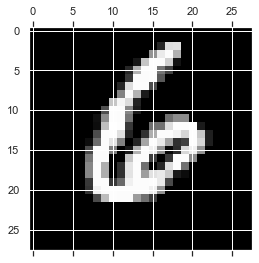

In [2]:
plt.gray()
print("El elemento 13 del conjunto de datos corresponde al número:",MNIST_train['target'][13])
plt.matshow(np.reshape(MNIST_train['data'][13],(28,28)))
plt.show()

# ¿Cuál es el ejercicio? Clasificar correctamente los números usando la misma regresión lineal.

¿Tiene sentido esto? Bueno, vamos a descubrir. Esa es la escencia de la Ciencia, la exploración.

El conjunto de datos que deberá clasificar correctamente es el correspondiente al último número de su código. Por ejemplo, el mío siendo $200810693$ sería el conjunto del número $3$; defina una variable global llamada `digit` con este valor. Es decir, quiero encontrar un algoritmo que me identifique de las $60k$ imágenes aquellas que sean el número $3$. Por simplicidad, puedo asumir que cualquier imagen que corresponda a un número diferente del $3$ es como si fuera $0$ y la que corresponda al número $3$ es como si fuera $1$. Lo que quiere decir que tenemos que <u>redefinir</u> `target`. *E.g.* si $\mathbf{target}=\{0,5,3,4,3,8,7,2,1,\dots\}$ entonces $\mathbf{target\_new}=\{0,0,1,0,1,0,0,0,0,\dots\}$. A continuación, defina en el dictionario `MNIST_train` una nueva llave `target_new` que contenga estas nuevas etiquetas.

In [3]:
digit=3
n_dig= np.sum(np.sum(MNIST_train['target'] == digit))
n_ft=MNIST_train['data'].shape[1]

In [4]:
redefTarget = lambda x,y: 1 if x==y else 0
redefTarget = np.vectorize(redefTarget,excluded=(1,))
MNIST_train['target_new'] = redefTarget(MNIST_train['target'],digit)

In [5]:
print("Verificamos")
print("\t¿cuántos con %d? %d"%(digit,n_dig))
print("\t¿la suma de 'target_new'? %d"%np.sum(MNIST_train['target_new']))

Verificamos
	¿cuántos con 3? 6131
	¿la suma de 'target_new'? 6131


# La siguiente parte es intentar hacer un *ajuste no-lineal* ligeramente <u>parecido</u> al ejemplo lineal
El ajuste lineal que vamos a hacer tiene que ver con el peso que va a tener el conjunto de datos con mi `digito` seleccionado sobre el total de datos para el *ajuste* (entrenamiento). Si sólo el $\sim10\%$ de los datos corresponde a mi dígito, la regresión con `target_new` podría ajustarse tranquilamente sólo a los ceros y tener una precisión del $\sim90\%$, algo que a priori diríamos que está genial, pero si nos damos cuenta el ajuste que tendríamos sería incapaz de reconocer mi `digito` de los demás. Por ende, es necesario saber cuantos elementos del **set** de entrenamiento tengo iguales a mi dígito y elegir el mismo número de elementos no iguales a mi dígito para crear el **set completo** de entrenamiento; llamemos a este número $n_{dig}$. Por otra parte, vamos a denotar $n_{ft}$ el número de parámetros del sistema; para este caso tengamos presente que són $784$ el mismo número que pixeles de la imagen. Luego, para el ajuste, debo seleccionar el mismo número de elementos complementarios. Es decir, que si mi `digito` es $3$ debo escoger $6131$ datos cuyo dígito sea cualquiera menos el $3$ ya que el set tiene $6131$ elementos del $3$. A continuación, cree dos matrices y el vector "respuesta": una que tenga los datos de los aciertos a su dígito y otra que tenga los datos de desaciertos (recomiendo que los elija al azar usando, por ejemplo, la función `np.random.choice`). Una vez haya hecho esto concaténelos usando `np.concatenate` y cree las matrices `A` y `Y` del **set completo**

In [6]:
A_aciertos = MNIST_train['data'][MNIST_train['target'] == digit]
Y_aciertos = MNIST_train['target_new'][MNIST_train['target'] == digit]
A_desaciertos = MNIST_train['data'][MNIST_train['target'] != digit]
Y_desaciertos = MNIST_train['target_new'][MNIST_train['target'] != digit]
# Elijo al azar el mismo número de aciertos para mi matriz de desaciertos
filas = np.random.choice(A_desaciertos.shape[0], size=n_dig, replace=False)
A_desaciertos = A_desaciertos[filas, :]
Y_desaciertos = Y_desaciertos[filas]
labels_aciertos = MNIST_train['target'][MNIST_train['target'] == digit]
labels_desaciertos = (MNIST_train['target'][MNIST_train['target'] != digit])[filas]

In [7]:
print("Dimension de matrices:")
print("\tA_aciertos:",A_aciertos.shape," y Y_aciertos:",Y_aciertos.shape)
print("\tA_desaciertos:",A_desaciertos.shape," y Y_desaciertos:",Y_desaciertos.shape)

Dimension de matrices:
	A_aciertos: (6131, 784)  y Y_aciertos: (6131,)
	A_desaciertos: (6131, 784)  y Y_desaciertos: (6131,)


In [8]:
A = np.concatenate((A_aciertos,A_desaciertos)).astype(np.float64)/256
Y = np.concatenate((Y_aciertos,Y_desaciertos)).astype(int)
labels = np.concatenate((labels_aciertos,labels_desaciertos)).astype(np.int8)
del A_aciertos,Y_aciertos,A_desaciertos,Y_desaciertos,labels_aciertos,labels_desaciertos

In [9]:
print("A shape:",A.shape)
print("Y shape:",Y.shape)
print("labels shape:",labels.shape)

A shape: (12262, 784)
Y shape: (12262,)
labels shape: (12262,)


# Ahora realice el ajuste encontrando $\mathbb{X}_{opt}$

El ajuste *lineal* que vamos a hacer no es evidente ya que la función más adecuada para este sistema es la sigmoidal. Recordemos,
$$\hat{y}_j=\frac{1}{1+e^{-\mathbb{A}^{(j)}\cdot\mathbb{X}_{opt}}},$$
donde $j$ es el índice del dato de los $2n_{dig}$ posibles; es decir, $\mathbb{A}^{(j)}$ es la $j-\text{ésima}$ fila de la matriz $\mathbb{A}$ y $\hat{y}_j$ es la predicción del modelo respecto a si la imagen es un $3$ u otro número diferente cuando $\hat{y}_j\to1$ o $\hat{y}_j\to0$ respectivamente.
<!-- $\mathbb{A}\mathbb{X}_{opt} = \hat{\mathbb{Y}}$ tal que $L(\hat{\mathbb{Y}},\mathbb{Y})=\frac{1}{4n_{dig}}\Vert\hat{\mathbb{Y}}-\mathbb{Y}\Vert^2$ sea lo mínimo posible -->
Ahora la pregunta es ¿cuál va a ser la función de costo? En este caso, se utiliza una función muy especial llamada la entropía cruzada (por sus siglas en inglés *crossed entropy*) definida así,
$$L(\hat{\mathbb{Y}},\mathbb{Y})=-\frac{1}{2n_{dig}}\sum_{j=1}^{2n_{dig}}\left[y_j\log\hat{y}_j+(1-y_j)\log(1-\hat{y}_j)\right].$$
El signo negativo es porque $0<\hat{y}_j<1$ con lo cual $\log\hat{y}_j<0$ y $\log(1-\hat{y}_j)<0$ pero tienden a cero cuando los ajustes son perfectos. Una observación, noten como esos dos términos están convenientemente definidos: $y_j$ es o cero o $1$ con lo cual, dependiendo del caso, sobrevive sólo uno de los términos. Esta definición es muy conveniente y se parece a la definición de la entropía de Shannon. ¡Una cosa interesante de esta definición es el mínimo! Está garantizada que esta es una función convexa y tiene un mínimo. ¿Cuál es el gradiente? (es importante que ustedes lo demuestren por su cuenta)
$$\vec{\nabla}_{\mathbb{X}_{opt}}L=\frac{1}{2n_{dig}}\mathbb{A}^\text{T}\cdot(\hat{\mathbb{Y}}-\mathbb{Y}),$$
con $\hat{\mathbb{Y}}$ y $\mathbb{Y}$ los vectores columna de las predicciones y las etiquetas reales.

Escriba las funciones de costo y su jacobiano (derivada) y resuelva usando SciPy `minimize` (recomiendo usar los siguientes parámetros para la función: `method='L-BFGS-B', tol=1e-8`)

In [11]:
def sigmoid(X,A):
    return 1/(1+np.exp(-np.dot(A,X)))
def L(X,A,Y):
    n,m = A.shape
    Y_hat = sigmoid(X,A)
    t1 = np.dot(Y,np.log(Y_hat))
    t2 = np.dot((1-Y),np.log(1-Y_hat))
    return -(t1+t2)/n
def Jac(X,A,Y):
    n,m = A.shape
    Y_hat = sigmoid(X,A)
    return np.dot(A.T,(Y_hat-Y)/n)

In [12]:
minimize(fun=L,jac=Jac, x0=np.random.uniform(size=n_ft), args = (A,Y), method='L-BFGS-B', tol=1e-8)

FloatingPointError: divide by zero encountered in log

# ¿Problemas? hay muchos ceros... ¿Qué hacemos? PCA

El problema que se presenta es debido a que todas las $784$ variables (correspondientes a los pixeles que serían los features) no son necesarios y se representa con que la matriz $\mathbb{A}^{\text{T}}\mathbb{A}$ es invertible (**¡ensáyenlo por favor!**). La solución está a la vista con un Análisis de Componentes Principales. Luego, realice el respectivo análisis de la matriz $\mathbb{A}$ y escoja $n_{pca}=2, 3, 10, 100, 300$ componentes y haga la optimización calculando así los coeficientes para los componentes principales que me ayudan a clasificar si una imagen corresponde a un $3$ u otro número. Ojo, en mi caso tengo que clasificar las imágenes con el número $3$. Tengan presente que aquí el problema cambia ligeramente,
$$\hat{y}_j=\frac{1}{1+e^{-\mathbb{A}_{pca}^{(j)}\cdot\tilde{\mathbb{X}}_{opt}}},$$
siendo $\tilde{\mathbb{X}}_{opt}$ los pesos que optimizan la predicción de nuestro algoritmo para los $n_{pca}$ componentes principales.

Por simplicidad utilice la librería `sklearn` como lo hicieron en el laboratorio. Por simplicidad, llame a la nueva matriz $\mathbb{A}_{pca}$. Les recomiendo revisar la proporción de varianza acumulada con el número de componentes mediante la propiedad de la clase PCA de `sklearn` llamada `explained_variance_ratio_` que les permitirá hacer una gráfica. Pueden revisar más en detalle en el siguiente [vínculo](https://mscipio.github.io/post/pca-tutorial-using-scikit-learn-python-module/). Hay una librería que desarrollaron para complementar el paquete de funciones gráficas de `sklearn` y dentro de ellas aparecen dos gráficas que me gustaría que ensayaran como se verían con nuestros datos. La librería se llama [SciKit-Plot](https://scikit-plot.readthedocs.io/en/stable/decomposition.html).

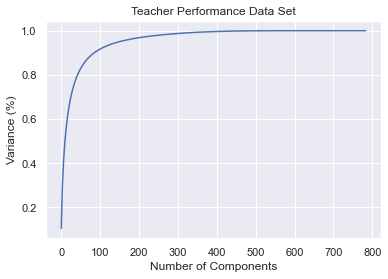

In [13]:
def plotPCA(X):
    #Fitting the PCA algorithm with our Data
    pca = PCA().fit(X)
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Teacher Performance Data Set')
    # plt.savefig(DIRECTORY+filename+'.pdf', format='pdf', dpi=150)
    plt.show()
plotPCA(A)

In [14]:
n_pca=2
pca = PCA(n_components=n_pca)
pca.fit(A)
A_pca = pca.transform(A)

In [15]:
opt = minimize(fun=L,jac=Jac, x0=np.random.uniform(size=n_pca), args = (A_pca,Y), method='L-BFGS-B', tol=1e-8)
Xtilde_opt = opt.x
Yhat = sigmoid(Xtilde_opt,A_pca)
opt

      fun: 0.3769189063439585
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.01896433e-07, -1.13164519e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7
      nit: 6
   status: 0
  success: True
        x: array([ 1.02624575, -0.22475334])

# Ahora que ustedes encontraron $\tilde{\mathbb{X}}_{opt}$ calculemos la precisión de nuestro algoritmo

Para hacerlo debemos calcular $\hat{\mathbb{Y}}$ pero tenga presente que este es un número entre $0$ y $1$. Sin embargo, para comparar con los datos que tenemos debemos redondear. La regla es que si el valor es inferior a $0.5$ entonces redondeo a cero y superior redondeo a $1$. Al realizar eso, podemos comparar para sacar la precisión.

> Para que puedan probar si están haciendo bien el cálculo, cuando ustedes escogen <u>sólo</u> $2$ componentes la precisión es superior a $\sim83\%$. ¡Imagínense el **poder** que tiene una simple regresión!

Adicionalmente, deben graficar la primera componente vs la segunda componente para los diferentes grupos de etiquetas. Recomiendo usar `scatterplot` de Seaborn. Les dejo a continuación unas gráficas bonitas, que es lo que quisiera que ver, para que vean el comportamiento de los grupos.

![3 vs 0](plot-3-0.png)
![3 vs 1](plot-3-1.png)
![3 vs 2](plot-3-2.png)
![3 vs 4](plot-3-4.png)
![3 vs 5](plot-3-5.png)
![3 vs 6](plot-3-6.png)
![3 vs 7](plot-3-7.png)
![3 vs 8](plot-3-8.png)
![3 vs 9](plot-3-9.png)

In [16]:
labeler = lambda x,y:0 if x<y else 1
labeler = np.vectorize(labeler,excluded=(1,))

In [17]:
Yhat_=labeler(Yhat,0.5)
print("precision: %.2f%%"%(100*np.sum(Yhat_ == Y)/len(Y)))

precision: 83.36%


In [18]:
# Yhatfilter = Yhat[Yhat_ == Y]
# Yfilter = Y[Yhat_ == Y]
# idx = np.random.choice(np.argsort(Yhatfilter), 1000, replace=False)
# plt.plot((0.5,0.5),(0,1),color='r')
# plt.scatter(Yhatfilter[idx],Yfilter[idx])

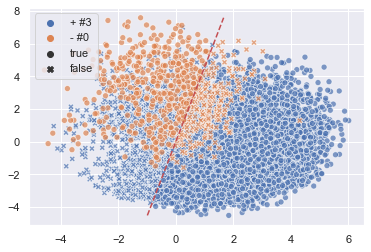

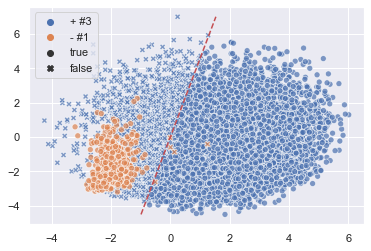

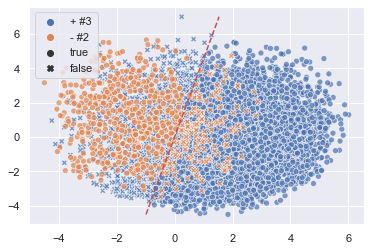

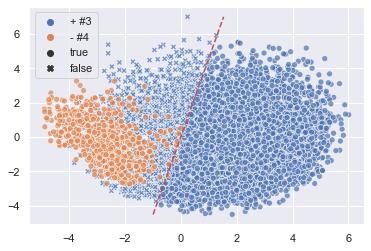

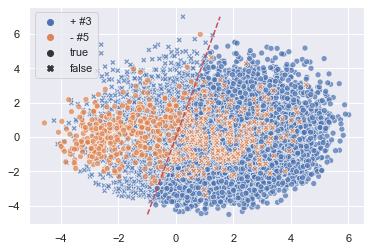

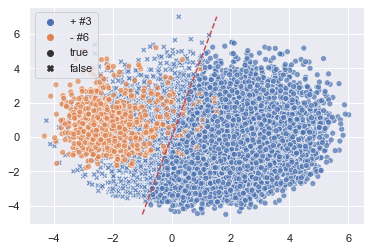

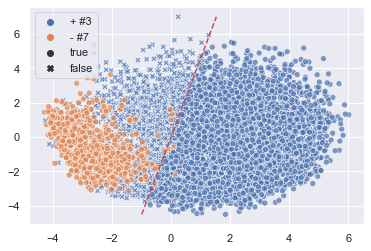

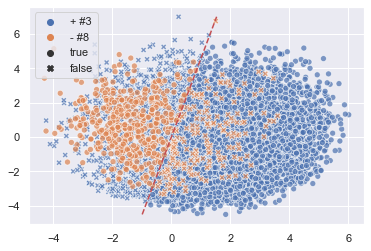

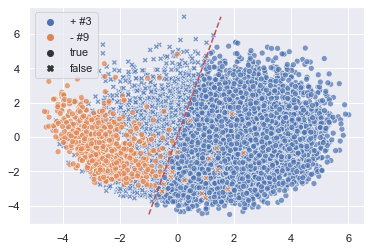

In [23]:
for other_digit in range(10):
    if other_digit != digit:
        filtrado = np.logical_or(labels == digit,labels == other_digit)
        lbl = labels[filtrado].astype(str); lbl[lbl!=str(digit)] = '- #'+str(other_digit); lbl[lbl==str(digit)] = '+ #'+str(digit)
        sty = (1*(Yhat_ == Y)[filtrado]).astype(str); sty[sty=='1'] = 'true'; sty[sty=='0'] = 'false'
        x = A_pca[filtrado,0]
        y = A_pca[filtrado,1]
        sns.scatterplot(x,y,hue=lbl,style=sty,alpha=0.7)
        # plot de la frontera de decision
        xm = x.min(); xM = x.max(); ym = y.min(); yM = y.max();
        xmy = -Xtilde_opt[0]*xm/Xtilde_opt[1]
        xMy = -Xtilde_opt[0]*xM/Xtilde_opt[1]
        ymx = -Xtilde_opt[1]*ym/Xtilde_opt[0]
        yMx = -Xtilde_opt[1]*yM/Xtilde_opt[0]
        p1 = (xm,xmy) if xmy > ym and xmy < yM else (ymx,ym)
        p2 = (xM,xMy) if xMy > ym and xMy < yM else (yMx,yM)
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]),ls='--',color='r')
        # plt.savefig('plot-3-'+str(other_digit)+'.png', format="png", dpi=150)
        plt.show()

# Finalmente, cómo me gusta complicar las cosas...

Cómo se podrán dar cuenta, para poder identificar un número de otro, es necesario tomar diferencias en patrones y qué mejor sistema de identificación de patrones que... Fourier. Asumiendo que el periodo $T=783$, calculen los coeficientes de la representación en serie de Fourier para cada una de las imágenes. ¿Cuántos coeficientes deben calcular? aunque me gustaría que ustedes calculasen este número prefiero decirles y que cada uno después intente responder esa pregunta. Dado que tenemos $784$ puntos, podríamos calcular $784$ coeficientes. Algo conforme a la información existente. Entonces para los coeficientes de la serie Seno y Coseno podría calcular $392$. En la práctica, ¿cuántos voy a necesitar? Esta es la pregunta que quiero que resuelvan a la vez que deben hacer una optimización de la forma:
$$\hat{y}_j=\frac{1}{1+e^{-\mathbb{A}_{fourier}^{(j)}\cdot\bar{\mathbb{X}}_{opt}}},$$
siendo $\bar{\mathbb{X}}_{opt}$ los pesos que optimizan la predicción de nuestro algoritmo para los $n_{fourier}$ componentes de Fourier que utilizo. Ustedes se preguntarán, y ¿por qué podemos hacer esto? la respuesta está, para quienes quieran leer un poco más, en las redes neuronales convolucionadas. Deben realizar las mismas gráficas del análisis anterior con PCA.

Recomendación, utilice las funciones `SFourier` e `int_cuadrada_trapecio` que escribimos en clase para calcular los coeficientes de Fourier debido a que es una partición simétrica del intervalo.

In [43]:
def int_cuadrada_trapecio(f,a,b):
    N = len(f)-1
    assert a<b
    Delta = (b-a)/N
    x_i = np.linspace(a,b,N+1)
    # f tiene que ser una función vectorizada
    f_xi = f
    # estimación media excluye el último punto
    area = (0.5*f_xi[0]+np.sum(f_xi[1:-1])+0.5*f_xi[-1])*Delta
    return area
def SFourier(y,T,kMax=50):
    # y tiene un numero determinado de datos
    N = len(y)
    t = np.linspace(0,T,N)
    a = []
    b = []
    for k in range(kMax+1):
        wk = 2*np.pi*k/T
        # Usando la función de integración de trapecio con intervalos uniformes
        ak = (2/T)*int_cuadrada_trapecio(y*np.cos(wk*t),0,T)
        bk = (2/T)*int_cuadrada_trapecio(y*np.sin(wk*t),0,T)
        a.append(ak)
        b.append(bk)
    return a,b
def transformA(M,N=15):
    # Escriba aquí la función teniendo en cuenta que si N=15
    # usted va a escoger 31 elementos de la serie: 1 del a_0
    # + 15 primeros de la serie coseno y 15 primeros de la
    # serie seno
    n,m=M.shape
    newM = np.zeros(shape=(n,2*N+1))
    for it in range(n):
        a,b = SFourier(M[it],783,N)
        newM[it] = np.concatenate(([a[0]],a[1:],b[1:]))
    return newM.copy()

In [58]:
n_fourier = 1
A_fourier = transformA(A,n_fourier)

In [59]:
opt = minimize(fun=L,jac=Jac, x0=np.random.uniform(size=2*n_fourier+1), args = (A_fourier,Y), method='L-BFGS-B', tol=1e-8)
Xhat_opt = opt.x
Yhat = sigmoid(Xhat_opt,A_fourier)
opt

      fun: 0.5112804839463284
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.49319904e-07, -7.15059185e-08, -1.82766980e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 12
   status: 0
  success: True
        x: array([19.03437564, 53.63435678,  7.2702052 ])

In [60]:
Yhat_=labeler(Yhat,0.5)
print("precision: %.2f%%"%(100*np.sum(Yhat_ == Y)/len(Y)))

precision: 77.42%


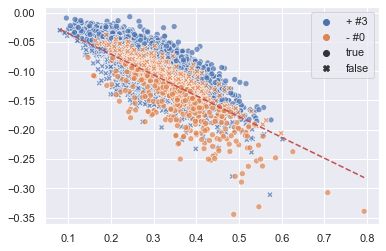

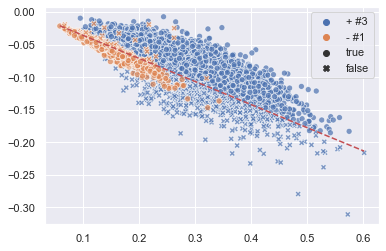

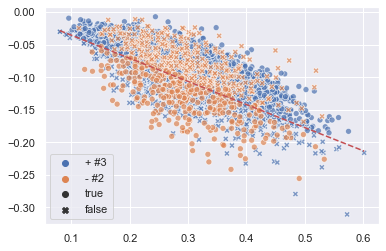

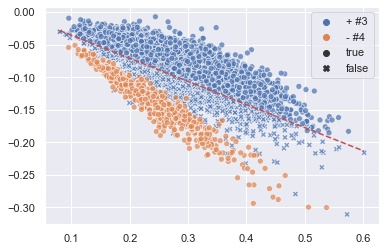

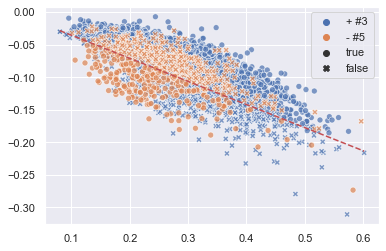

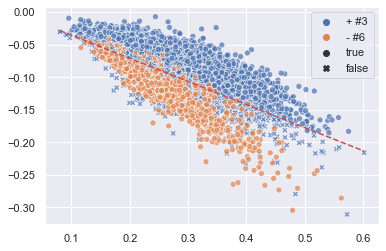

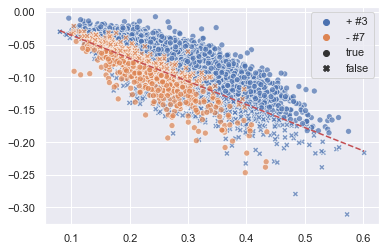

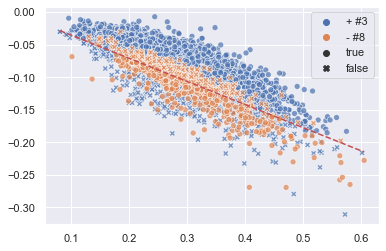

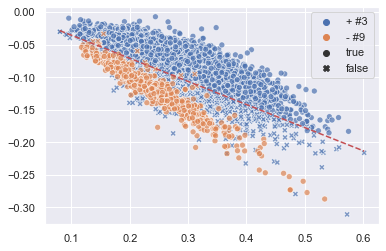

In [63]:
for other_digit in range(10):
    if other_digit != digit:
        filtrado = np.logical_or(labels == digit,labels == other_digit)
        lbl = labels[filtrado].astype(str); lbl[lbl!=str(digit)] = '- #'+str(other_digit); lbl[lbl==str(digit)] = '+ #'+str(digit)
        sty = (1*(Yhat_ == Y)[filtrado]).astype(str); sty[sty=='1'] = 'true'; sty[sty=='0'] = 'false'
        x = A_fourier[filtrado,0]
        y = A_fourier[filtrado,1]
        sns.scatterplot(x,y,hue=lbl,style=sty,alpha=0.7)
        # plot de la frontera de decision
        xm = x.min(); xM = x.max(); ym = y.min(); yM = y.max();
        xmy = -Xhat_opt[0]*xm/Xhat_opt[1]
        xMy = -Xhat_opt[0]*xM/Xhat_opt[1]
        ymx = -Xhat_opt[1]*ym/Xhat_opt[0]
        yMx = -Xhat_opt[1]*yM/Xhat_opt[0]
        p1 = (xm,xmy) if xmy > ym and xmy < yM else (ymx,ym)
        p2 = (xM,xMy) if xMy > ym and xMy < yM else (yMx,yM)
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]),ls='--',color='r')
        # plt.savefig('plot-3-'+str(other_digit)+'.png', format="png", dpi=150)
        plt.show()

# ¡Espero se diviertan! Buena suerte a tod@s